In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [9]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [10]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [11]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [24]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Latest: {recent_date[0]}")

Latest: 2017-08-23


In [25]:
#get date from 1 year ago
recent_date_query = dt.datetime.strptime(recent_date[0], '%Y-%m-%d')
query_date = dt.date(recent_date_query.year -1, recent_date_query.month, recent_date_query.day)
query_date

datetime.date(2016, 8, 23)

In [33]:
#create main df
sel = [Measurement.date,Measurement.prcp]
query_results = session.query(*sel).filter(Measurement.date >= query_date).all()

precipitation_df = pd.DataFrame(query_results, columns=['Date','Precipitation'])
precipitation_df.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [32]:
#create iterations of df just in case
precipitation_clean = precipitation_df.dropna(how='any')
precipitation_sort = precipitation_clean.sort_values(["Date"], ascending=True)
precipitation_final = precipitation_sort.set_index("Date")
precipitation_final.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


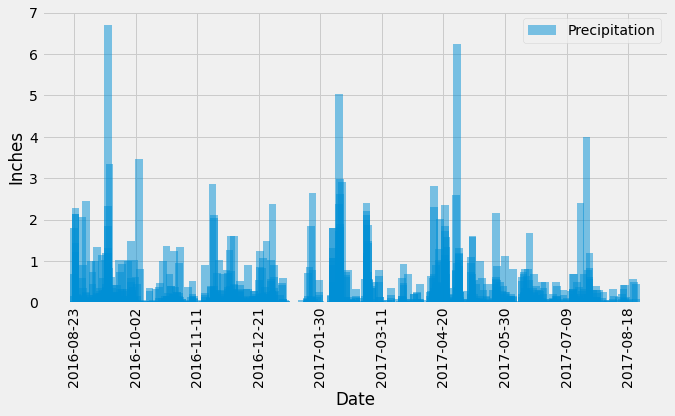

In [65]:
#dataframe bar graph plot
plt.figure(figsize=(10,5))
plt.bar(precipitation_final.index, precipitation_final['Precipitation'], alpha=.5, align="center", width=5, label="Precipitation")

ticks_range = np.arange(0,400,40)
plt.xticks(ticks_range, rotation=90)

plt.xlabel("Date")
plt.ylabel("Inches")
plt.grid(axis='both', linestyle='-')
plt.legend()
plt.show()

In [66]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_final.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [68]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station.id).count()
station_count

9

In [69]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station,func.count(Measurement.id)]
active_stations = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [74]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.round(func.avg(Measurement.tobs),2)]
most_active_station = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).first()
print(f'The lowest temp is {most_active_station[0]}.  The highest temp is {most_active_station[1]}.  The average temp is {most_active_station[2]}.')

The lowest temp is 54.0.  The highest temp is 85.0.  The average temp is 71.66.


In [86]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_year = session.query(Measurement.tobs).filter(Measurement.station == active_stations[0][0]).filter(Measurement.date >= query_date).all()
frequency = list(np.ravel(most_active_station_year))

In [87]:
sel = [Station.station,Station.name]
most_active_station_year = session.query(*sel).all()
station_desc_year = pd.DataFrame(most_active_station_year, columns=['Station','Name'])
station_desc_year

,Station,Name
0,USC00519397,"WAIKIKI 717.2, HI US"
1,USC00513117,"KANEOHE 838.1, HI US"
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
3,USC00517948,"PEARL CITY, HI US"
4,USC00518838,"UPPER WAHIAWA 874.3, HI US"
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US"
6,USC00519281,"WAIHEE 837.5, HI US"
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US"
8,USC00516128,"MANOA LYON ARBO 785.2, HI US"


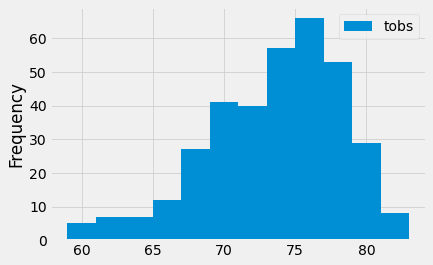

In [88]:
station_name = station_desc_year.loc[station_desc_year["Station"] == active_stations[0][0],"Name"].tolist()[0]

plt.hist(temps, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Close session

In [89]:
# Close Session
session.close()